In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Análisis exploratorio y construcción del grafo a partir de Elliptic Graph Dataset

In [ ]:
# 1. Cargar el CSV
df = pd.read_csv("../data/elliptic_graph_dataset.csv")

## Descripción del dataset
"We contribute the Elliptic Data Set, a time series graph of over 200K Bitcoin transactions (nodes), 234K directed payment flows (edges), and 166 node features, including ones based on non-public data;"
 Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics

31 Jul 2019  ·  Mark Weber, Giacomo Domeniconi, Jie Chen, Daniel Karl I. Weidele, Claudio Bellei, Tom Robinson, Charles E. Leiserson ·
https://paperswithcode.com/paper/anti-money-laundering-in-bitcoin

In [8]:
df.columns

Index(['person_id_from', 'person_id_to', 'fraud_label', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6',
       ...
       'feature_155', 'feature_156', 'feature_157', 'feature_158',
       'feature_159', 'feature_160', 'feature_161', 'feature_162',
       'feature_163', 'feature_164'],
      dtype='object', length=168)

In [12]:
df.head()

,person_id_from,person_id_to,fraud_label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164
0,0,1,2,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,2,3,2,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,4,5,2,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579381,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
3,6,7,2,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,8,9,2,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.128722,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521400


person_id_from: nodo origen (quien envía)

person_id_to: nodo destino (quien recibe)

fraud_label: etiqueta (fraudulento o no)

feature_0 a feature_164: características del nodo origen o de la transacción

In [24]:
# ¿Hay múltiples vectores de features para un mismo person_id_from?
df.groupby('person_id_from')[[f'feature_{i}' for i in range(165)]].nunique().max().max()


np.int64(1)

In [25]:

# Seleccionar solo las columnas de features
feature_cols = [f'feature_{i}' for i in range(165)]  # o 165 si estás seguro de que llegan a feature_164

# Calcular cantidad y porcentaje de nulos por columna
null_counts = df[feature_cols].isnull().sum()
null_percent = (null_counts / len(df)) * 100

# Unir en un solo DataFrame para inspección
null_summary = pd.DataFrame({
    'null_count': null_counts,
    'null_percent': null_percent
}).sort_values(by='null_percent', ascending=False)

print(null_summary.head(10))  # Las 10 features con más nulos


           null_count  null_percent
feature_0           0           0.0
feature_1           0           0.0
feature_2           0           0.0
feature_3           0           0.0
feature_4           0           0.0
feature_5           0           0.0
feature_6           0           0.0
feature_7           0           0.0
feature_8           0           0.0
feature_9           0           0.0


## Construcción del grafo

Grafo dirigido (nx.DiGraph)

Nodos con features

Aristas con fraud_label

In [15]:
# 2. Crear el grafo dirigido (el flujo tiene dirección)
G = nx.DiGraph()

In [16]:
# 3. Agregar nodos y aristas
for _, row in df.iterrows():
    src = row['person_id_from']
    dst = row['person_id_to']
    
    # Agregar nodos si no existen, con sus features
    if src not in G:
        features_src = row[[f'feature_{i}' for i in range(165)]].tolist()
        G.add_node(src, features=features_src)
    if dst not in G:
        # Podés asignar features vacías si no tenés info del nodo destino
        G.add_node(dst, features=[None]*165)

    # Agregar arista con la etiqueta de fraude
    G.add_edge(src, dst, fraud_label=row['fraud_label'])

print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")



Nodos: 203769, Aristas: 234355


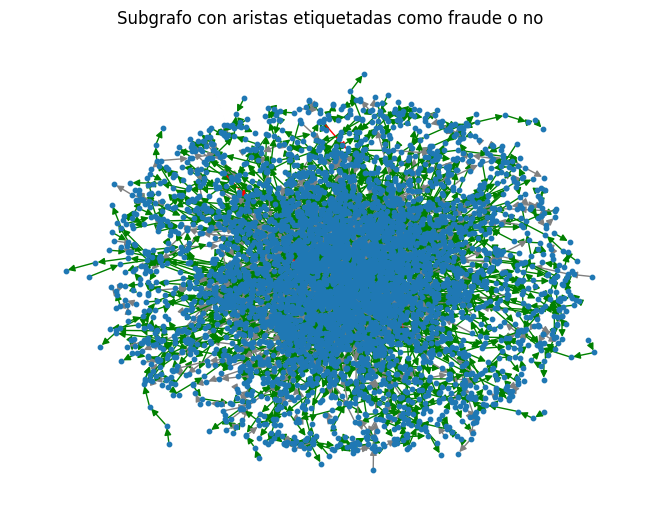

In [ ]:
# 4. Visualizar una parte del grafo (opcional)
subgraph = G.subgraph(list(G.nodes)[:5000])  # muestra 100 nodos
pos = nx.spring_layout(subgraph, seed=42)

# Colores según si la arista es fraudulenta
edge_colors = []
for u, v in subgraph.edges():
    label = subgraph[u][v].get('fraud_label')
    if label == 1:
        edge_colors.append('red')
    elif label == 2:
        edge_colors.append('green')
    else:
        edge_colors.append('gray')

nx.draw(subgraph, pos, with_labels=False, node_size=10, edge_color=edge_colors)
plt.title("Subgrafo con aristas etiquetadas como fraude o no")
plt.show()




## Análisis exploratorio del grafo

### In-degrees y out-degrees

In [53]:
# Extraer grados
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Convertir a DataFrame para análisis
degree_df = pd.DataFrame({
    'node': list(G.nodes()),
    'in_degree': [in_degrees[n] for n in G.nodes()],
    'out_degree': [out_degrees[n] for n in G.nodes()]
})

In [54]:
# Estadísticas básicas
desc_stats = degree_df[['in_degree', 'out_degree']].describe()
print(desc_stats)


           in_degree     out_degree
count  203769.000000  203769.000000
mean        1.150101       1.150101
std         3.911132       1.894740
min         0.000000       0.000000
25%         0.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       284.000000     472.000000


In [55]:
print("Nodos con mayor in-degree:")
print(degree_df.sort_values('in_degree', ascending=False).head())

print("\nNodos con mayor out-degree:")
print(degree_df.sort_values('out_degree', ascending=False).head())


Nodos con mayor in-degree:
            node  in_degree  out_degree
51483    51371.0        284           0
51377    51437.0        247           0
148195  148292.0        241           0
35892    35892.0        239           0
24761    24761.0        212           0

Nodos con mayor out-degree:
            node  in_degree  out_degree
94301    94301.0          1         472
130        130.0          1         288
141818  141786.0          0         122
133793  133793.0          1         112
198381  198381.0          1          99


### Tipos de conexiones

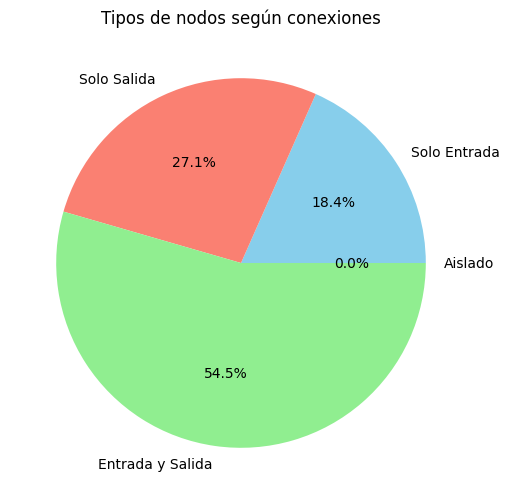

In [30]:
only_in = 0
only_out = 0
both = 0
isolated = 0

for n in G.nodes():
    in_d = G.in_degree(n)
    out_d = G.out_degree(n)
    
    if in_d > 0 and out_d == 0:
        only_in += 1
    elif in_d == 0 and out_d > 0:
        only_out += 1
    elif in_d > 0 and out_d > 0:
        both += 1
    else:
        isolated += 1

# Pie chart
labels = ['Solo Entrada', 'Solo Salida', 'Entrada y Salida', 'Aislado']
sizes = [only_in, only_out, both, isolated]
colors = ['skyblue', 'salmon', 'lightgreen', 'gray']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Tipos de nodos según conexiones")
plt.show()


### Etiquetas de transacciones

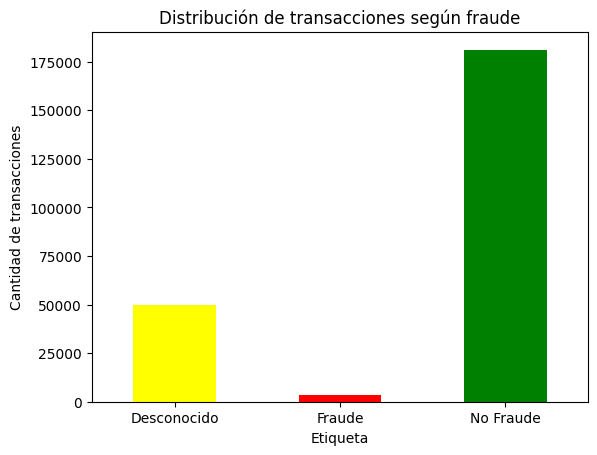

In [39]:
# Contar etiquetas de fraude en las aristas
labels = nx.get_edge_attributes(G, 'fraud_label')
fraud_counts = pd.Series(labels.values()).value_counts().sort_index()

# Reemplazar valores para que sean más claros
fraud_counts.index = fraud_counts.index.map({2: 'No Fraude', 1: 'Fraude', 0: 'Desconocido'})

# Bar chart
fraud_counts.plot(kind='bar', color=['yellow', 'red', 'green'])
plt.title("Distribución de transacciones según fraude")
plt.ylabel("Cantidad de transacciones")
plt.xlabel("Etiqueta")
plt.xticks(rotation=0)
plt.show()


In [56]:
from collections import defaultdict

fraud_out = defaultdict(int)
fraud_in = defaultdict(int)

for u, v, data in G.edges(data=True):
    label = data.get('fraud_label')
    if label == 1:  # Solo fraude confirmado
        fraud_out[u] += 1
        fraud_in[v] += 1


In [57]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

nodes_df = pd.DataFrame({
    'node': list(G.nodes()),
    'in_degree': [in_degrees[n] for n in G.nodes()],
    'out_degree': [out_degrees[n] for n in G.nodes()],
    'fraud_in': [fraud_in[n] for n in G.nodes()],
    'fraud_out': [fraud_out[n] for n in G.nodes()],
})

# Total y proporción de fraude
nodes_df['fraud_total'] = nodes_df['fraud_in'] + nodes_df['fraud_out']
nodes_df['fraud_ratio_in'] = nodes_df['fraud_in'] / nodes_df['in_degree'].replace(0, pd.NA)
nodes_df['fraud_ratio_out'] = nodes_df['fraud_out'] / nodes_df['out_degree'].replace(0, pd.NA)


In [58]:
print(nodes_df[['in_degree', 'out_degree', 'fraud_total']].corr())


             in_degree  out_degree  fraud_total
in_degree     1.000000   -0.010265     0.181857
out_degree   -0.010265    1.000000    -0.009742
fraud_total   0.181857   -0.009742     1.000000


In [59]:
print(nodes_df[['fraud_total', 'fraud_ratio_in', 'fraud_ratio_out']].describe())


         fraud_total
count  203769.000000
mean        0.033086
std         0.477749
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        68.000000


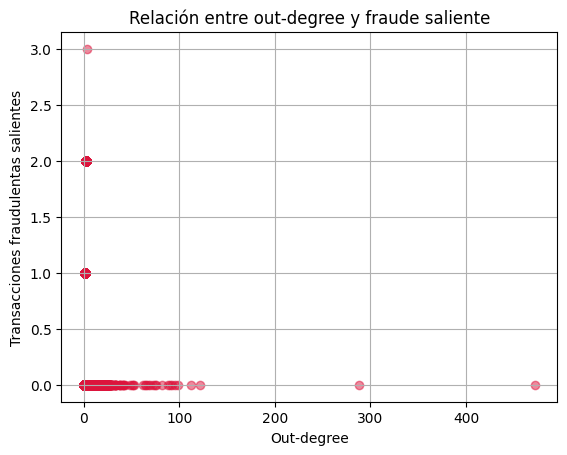

In [63]:

plt.scatter(nodes_df['out_degree'], nodes_df['fraud_out'], alpha=0.5, color='crimson')
plt.xlabel("Out-degree")
plt.ylabel("Transacciones fraudulentas salientes")
plt.title("Relación entre out-degree y fraude saliente")
plt.grid(True)
plt.show()


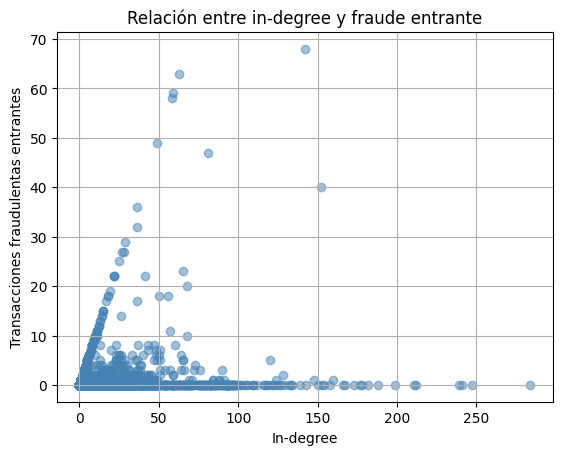

In [64]:
plt.scatter(nodes_df['in_degree'], nodes_df['fraud_in'], alpha=0.5, color='steelblue')
plt.xlabel("In-degree")
plt.ylabel("Transacciones fraudulentas entrantes")
plt.title("Relación entre in-degree y fraude entrante")
plt.grid(True)
plt.show()


## Comparación con grafo de torch-geom

In [49]:
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid

# Carga el dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(data)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [50]:

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / num_nodes

print(f"Tu grafo:\nNodos: {num_nodes}, Aristas: {num_edges}, Densidad: {density:.6f}, Grado medio: {avg_degree:.2f}")


Tu grafo:
Nodos: 203769, Aristas: 234355, Densidad: 0.000006, Grado medio: 2.30


In [51]:
cora_nodes = data.num_nodes
cora_edges = data.num_edges
cora_density = 2 * cora_edges / (cora_nodes * (cora_nodes - 1))  # grafo no dirigido
cora_avg_degree = cora_edges / cora_nodes

print(f"Cora:\nNodos: {cora_nodes}, Aristas: {cora_edges}, Densidad: {cora_density:.6f}, Grado medio: {cora_avg_degree:.2f}")


Cora:
Nodos: 2708, Aristas: 10556, Densidad: 0.002880, Grado medio: 3.90
